## Portfolio management using Markowitz optimization methodology
To use this project, provide the following information in the attached Excel sheet "Stocks_List.xlsx":

1. Tickers:  Enter tickers of the existing companies in your portfolio (e.g. AAPL for Apple)
2. Quantity: Enter the quantity of stocks owned for each company

The output is the best combination of stocks which minimizes the risk through minimizing the dependecies between the stocks in the portolio.

In [2]:
## Importing required libraries
library(fPortfolio)
library(readxl)
library(ggplot2)
library(dplyr)
library(quantmod)
library(PerformanceAnalytics)
library(PortfolioAnalytics)
library(ROI)
library(ROI.plugin.quadprog)
library(ROI.plugin.glpk)
library(zoo)

## Get stock prices

In [3]:
## Insert initial date and Risk Free rate
initial_day='2020-01-01'
rf=0
## Get the tickers from Excel sheet
stocks_list <- as.data.frame(read_excel("Stocks_List.xlsx"))
tickers <- t(stocks_list[[1]])

In [4]:
## Get Prices (can be daily, weekly or monthly)
stocks_prices <- NULL
for (Ticker in tickers){
  stocks_prices <- na.approx(cbind(stocks_prices,
                           getSymbols.yahoo(Ticker, from=initial_day, periodicity = "daily", auto.assign=FALSE)[,4])
  )
}

## Set your benchmark, default="SPY" 
bench_prices <- getSymbols.yahoo("SPY", from=initial_day, periodicity = "daily", auto.assign=FALSE)[,4]

## Create data frames for the Benchmark Prices (S&P500 in this case) and focused stocks
stocks_prices <- data.frame(date=index(stocks_prices), coredata(stocks_prices))
bench_prices <- data.frame(date=index(bench_prices), coredata(bench_prices))

## Setting date as index for both data frames
rownames(stocks_prices) <- stocks_prices$date
rownames(bench_prices) <- bench_prices$date
stocks_prices$date <- NULL
bench_prices$date <- NULL
colnames(stocks_prices) <- tickers
colnames(bench_prices) <- "SPY"

In [5]:
## Print the number of NA values to check discrepencies
## Evaluate the steps taken, if any non-zero number detected
colSums(cbind(is.na(bench_prices),is.na(stocks_prices)))

SPY  AAPL SFTBY    FB  NFLX 
    0     0     0     0     0

## Calculate daily returns

In [6]:
## Use only if you need to manipulate the data manually on Excel
## Create an Excel sheet of "stocks_prices" data frame
#write.xlsx(as.data.frame(stocks_prices), "result.xlsx", sheetName = "Sheet1",col.names = TRUE, row.names = TRUE)
#stocks_prices <- as.data.frame(read_excel("result.xlsx"))
#rownames(stocks_prices) <- stocks_prices[,1]
#stocks_prices[,1]<-NULL
#colSums(cbind(is.na(bench_prices),is.na(stocks_prices)))

In [7]:
## Weights of stock in the Current Portfolio
quants_prior <- stocks_list[[2]]
weights_prior <- quants_prior*tail(stocks_prices,1)/
  sum(stocks_list[[2]]*tail(stocks_prices,1))


## Calculate Returns For each company
stocks_daily_returns <- na.omit(ROC(stocks_prices, type="discrete"))
bench_daily_returns <- na.omit(ROC(bench_prices, type="discrete"))

colnames(stocks_daily_returns) <- tickers
colnames(bench_daily_returns) <- "SPY"

## Optimization model

In [8]:
## Depending on number of stocks in your portfolio, you need to try different values for min, max, min_sum, max_sum
portf <- portfolio.spec(colnames(stocks_daily_returns))

portf <- add.constraint(portf, type="weight_sum", min_sum=.95, max_sum=1.05)
portf <- add.constraint(portf, type="long_only")
portf <- add.constraint(portf, type="box", min=.03, max=1)
portf <- add.objective(portf, type="return", name="mean")
portf <- add.objective(portf, type="risk", name="StdDev")

## In this example, "ROI" is used as the solver. The method can be changed to "DEoptim", "random", "pso", "GenSA".
## Choosing the best solver is out of scope of this project
optPort <- optimize.portfolio(stocks_daily_returns, portf, optimize_method = "ROI",trace=TRUE)

## Numerical results

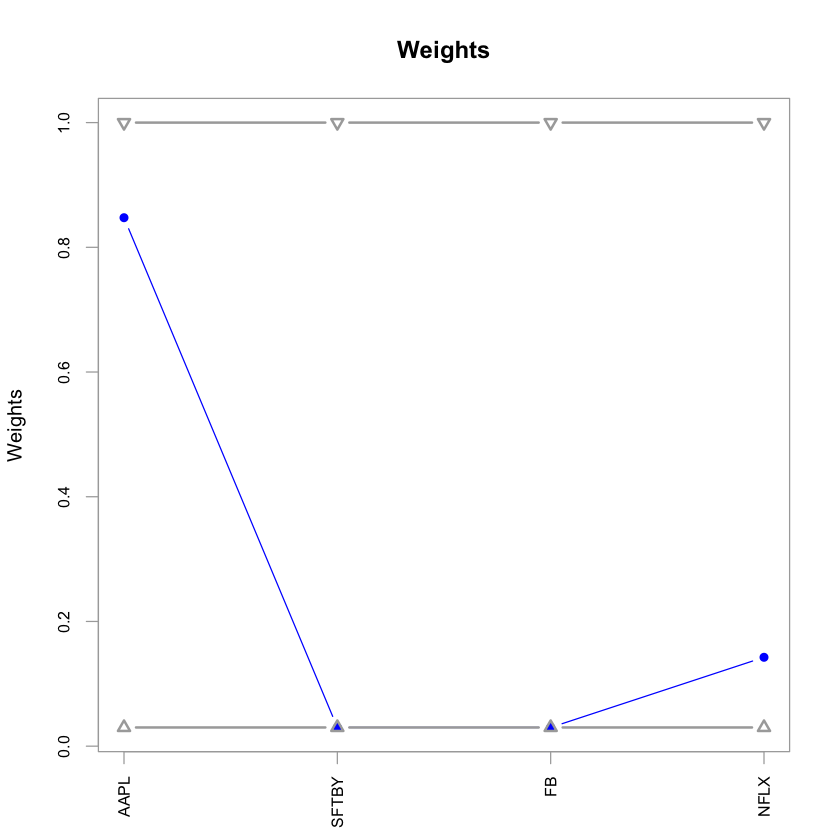

In [9]:
## Weights of stock in the Optimized Portfolio
weights_opt <- extractWeights(optPort)
chart.Weights(optPort)

## Quantity of stock in the Optimized Portfolio
quants_opt <- round(weights_opt*sum(stocks_list[[2]]*
                      tail(stocks_prices,1))/tail(stocks_prices,1))

## Since the numbers for quantities are rounded there is a difference between the value of total 
##  investments before and after the optimization process. The difference is:
#diff_invest <- sum((quants_opt-quants_prior)*tail(stocks_prices,1))

## Rebalancer

In [10]:
# The quantity of each stock to buy (+) or sell (-) to get to the Optimized Portfolio
buy_or_sell <- t(quants_opt-quants_prior)
buy_or_sell <- as.data.frame(cbind(buy_or_sell,buy_or_sell * t(tail(stocks_prices,1))))
colnames(buy_or_sell) <- c('Buy/Sell_qts','Amount')
buy_or_sell <- buy_or_sell[order(abs(buy_or_sell['Amount']),decreasing = TRUE),]
buy_or_sell

,Buy/Sell_qts,Amount
,<dbl>,<dbl>
AAPL,4,1989.92
NFLX,-3,-1476.93
SFTBY,-4,-119.24
FB,0,0.00


## Visualizations

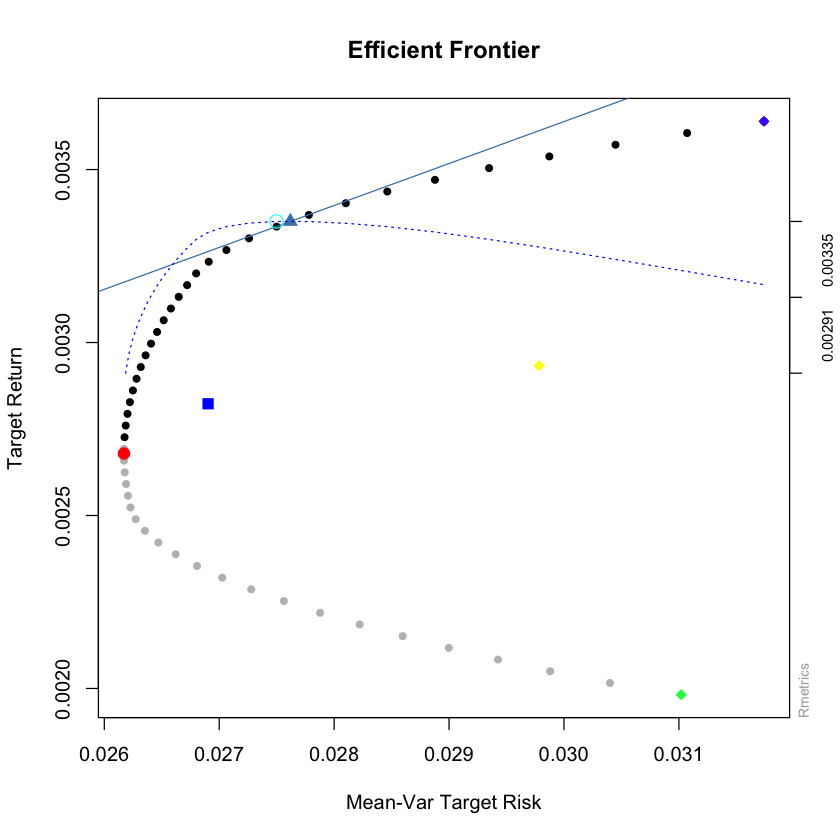

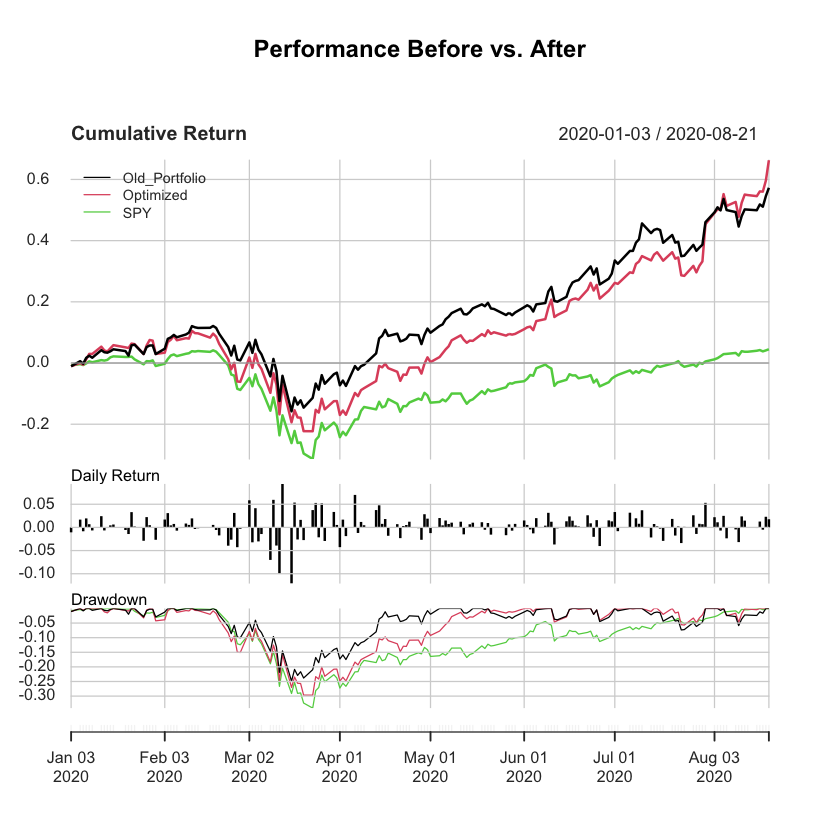

In [11]:
## Graph the Efficient Frontier
## 1: Efficient Frontier
## 2: Minimum variance portfolio
## 3: Tangency portfolio
## 4: Risk returns of each asset
## 5: Equal weight portfolio
## 6: Two asset frontiers (Long)
## 7: Mont Carlo portfolios
## 8: Sharpe Ratio

effFrontier <- portfolioFrontier(as.timeSeries(stocks_daily_returns),constraints = "LongOnly")
plot(effFrontier,c(1,2,3,4,5,8))


## Calculate Portfolio Returns
portfolioReturn <-    as.matrix(stocks_daily_returns)  %*%  as.matrix(t(weights_prior)) 
Opt_portfolioReturn <- as.matrix(stocks_daily_returns)  %*%  as.matrix(weights_opt) 

rets_df <- cbind(portfolioReturn, Opt_portfolioReturn, bench_daily_returns)
colnames(rets_df) = c("Old_Portfolio","Optimized","SPY")


## Plot Performance
charts.PerformanceSummary(as.xts(rets_df),Rf=rf,methods = "none",main="Performance Before vs. After")

## Performance results

In [12]:
## Sharpe Ratio comparision between before and after optimization

SharpeRatio(
  as.xts(rets_df),
  Rf=rf,
  p = 0.95,
  FUN = c("StdDev", "VaR", "ES"),
)

,Old_Portfolio,Optimized,SPY
"StdDev Sharpe (Rf=0%, p=95%):",0.11816239,0.11759692,0.023483721
"VaR Sharpe (Rf=0%, p=95%):",0.07290249,0.07801996,0.014171436
"ES Sharpe (Rf=0%, p=95%):",0.03978574,0.04544729,0.007629699


## Future progress
Using Apache Spark to Backtest the result presented.